# r/AnarchyChess Analysis
- focus on board 2

In [3]:
from PIL import Image
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import imageio.v2 as imageio  # for GIF creation
import os
from datetime import datetime
import pandas as pd
import matplotlib.dates as mdates

final_canvas = Image.open("2022_canvas_final.png") # load in final r/place 2022 canva

In [4]:
parquet_file = "2022pyarrow.parquet"

lf = pl.scan_parquet(parquet_file)  # LazyFrame (efficient for big data)
lf.collect().head()

timestamp,pixel_color,x,y,user_id_int
datetime[μs],str,i64,i64,u32
2022-04-04 00:53:51.577,"""#00CCC0""",826,1048,0
2022-04-04 00:53:53.758,"""#94B3FF""",583,1031,1
2022-04-04 00:53:54.685,"""#6A5CFF""",1873,558,2
2022-04-04 00:54:57.541,"""#009EAA""",1627,255,3
2022-04-04 00:55:16.307,"""#94B3FF""",49,1478,4


## board 1

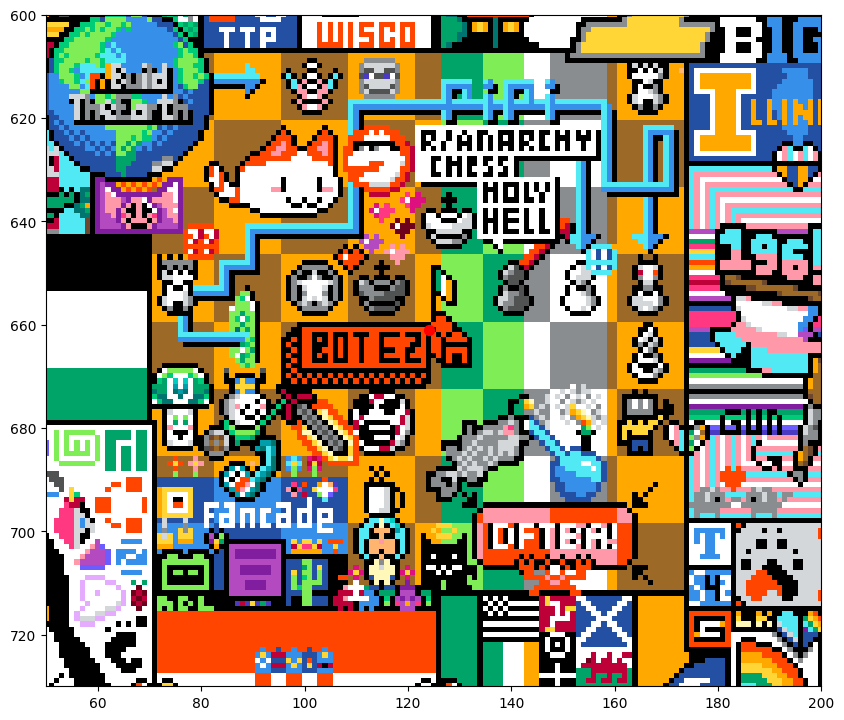

In [3]:
board1 = [(124, 661)] # center of board1

width, height = 200, 730 # zoom into these dim

# create figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(final_canvas)

# mark top pixels
for (x, y) in board1:
    ax.scatter(x, y, color='red', s=50)  # red dot at pixel location

ax.set_xlim(50, 200)  # adjust 
ax.set_ylim(730, 600)
plt.show()

## board 2

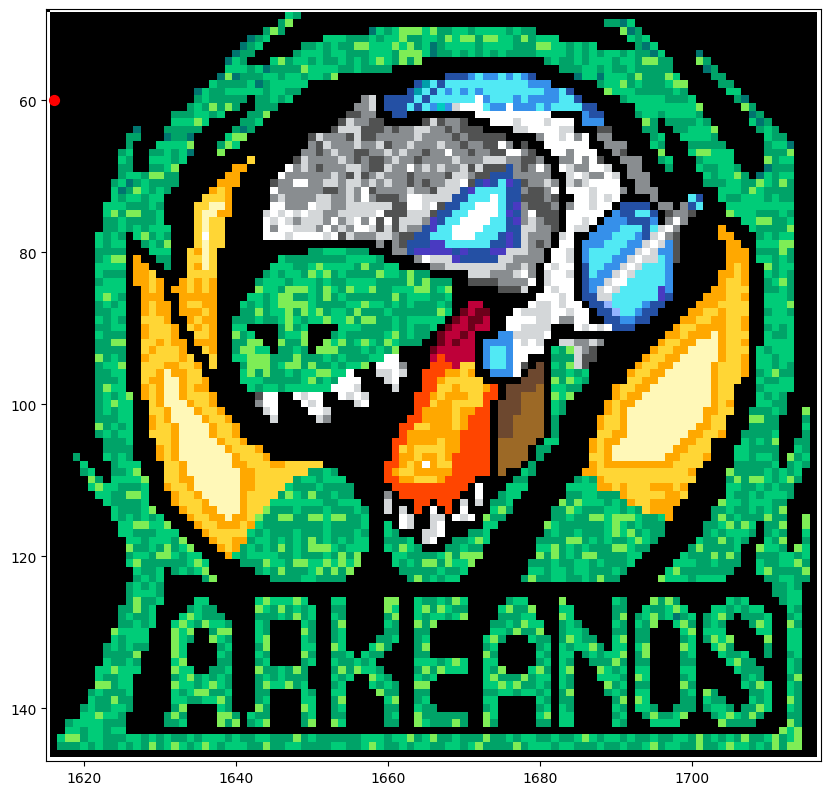

In [58]:
board2 = [(1616, 60)] # center of board

width, height = 2000, 100 # zoom into these dim

# create figure
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(final_canvas)

# mark top pixels
for (x, y) in board2:
    ax.scatter(x, y, color='red', s=50)  # red dot at pixel location

ax.set_xlim(1615, 1717)  # adjust 
ax.set_ylim(147, 48)
plt.show()

### Timelapse of Board 2

In [4]:
# define board2 coordinate range
x_min, x_max = 1615, 1717
y_min, y_max = 48, 147

# get values for timelapse
df_board2 = (
    lf.filter(
        (pl.col("x") >= x_min) & (pl.col("x") <= x_max) &
        (pl.col("y") >= y_min) & (pl.col("y") <= y_max) & # filter thru dims
        (pl.col("timestamp") >= pl.lit("2022-04-02 16:30:00").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")) # start time when board doubled
    )
    .with_columns(
        pl.col("timestamp").dt.truncate("30m").alias("time_bin")  # group into 30min bins
    )
    .group_by("time_bin", "x", "y")
    .agg(pl.col("pixel_color").last())  # Get the last pixel color per hour / get most common color
    .collect()
)

print(df_board2.shape)  # check final size
df_board2.head()

(110045, 4)


time_bin,x,y,pixel_color
datetime[μs],i64,i64,str
2022-04-04 23:30:00,1642,146,"""#FFFFFF"""
2022-04-04 23:30:00,1696,53,"""#FFFFFF"""
2022-04-04 10:30:00,1690,64,"""#FFA800"""
2022-04-04 17:30:00,1672,79,"""#7EED56"""
2022-04-03 09:00:00,1647,82,"""#FF4500"""


In [60]:
output_dir = "board2_frames" # directory to store images
os.makedirs(output_dir, exist_ok=True)

df_board2 = df_board2.sort("time_bin") # sort data by time_bin to process changes in chrono order
time_bins = df_board2["time_bin"].unique().sort() # unique timebins in order

# dictionary to store  last known color of each (x, y) pixel
pixel_state = {}  # Key = (x, y), Value = pixel_color

frames = []  # list to store images for GIF

# process each timestamp
for i, time_bin in enumerate(time_bins):
    df_snapshot = df_board2.filter(df_board2["time_bin"] == time_bin)

    # update pixel states with new colors
    for row in df_snapshot.iter_rows(named=True):
        x, y, color = row["x"], row["y"], row["pixel_color"]
        pixel_state[(x, y)] = color  # update last known color for this pixel

    fig, ax = plt.subplots(figsize=(8, 8)) # full frame 

    # convert stored pixel colors into lists for plotting
    if pixel_state:  # ensure there are pixels to plot
        x_coords, y_coords, colors = zip(*[(x, y, color) for (x, y), color in pixel_state.items()])
        ax.scatter(x_coords, y_coords, c=colors, s=5, marker='s')  # scatter plot with stored pixel colors

    ax.invert_yaxis()
    ax.set_title(f"r/AnarchyChess Board 2 at {time_bin}")

    frame_path = os.path.join(output_dir, f"frame_{i:03d}.png")
    plt.savefig(frame_path, dpi=300, bbox_inches='tight') # save frame

    plt.draw()
    buf = fig.canvas.tostring_rgb()
    img = np.frombuffer(buf, dtype=np.uint8).reshape(fig.canvas.get_width_height()[::-1] + (3,)) # convert plot to img for GIF
    frames.append(img)

    plt.close()

imageio.mimsave("board2_timelapse.gif", frames, duration=0.25)  # gif, 0.25s per frame

/var/folders/sc/9ntffqn97434sv_965czfhhc0000gn/T/ipykernel_80119/2601315388.py:35: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  buf = fig.canvas.tostring_rgb()


- focus on timeframes 2022-04-04 19:00:00 to 2022-04-04 19:30:00 (when takeover happens)

In [5]:
# define board2 coordinate range
x_min, x_max = 1615, 1717
y_min, y_max = 48, 147

# get values for timelapse
new = (
    lf.filter(
        (pl.col("x") >= x_min) & (pl.col("x") <= x_max) &
        (pl.col("y") >= y_min) & (pl.col("y") <= y_max) & # filter thru dims
        (pl.col("timestamp") >= pl.lit("2022-04-02 16:30:00").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")) # start time when board doubled
    )
    .with_columns(
        pl.col("timestamp").dt.truncate("1m").alias("time_bin")  # group into 1min bins
    )
    .group_by("time_bin", "x", "y")
    .agg(pl.col("pixel_color").last())  # get the last pixel color 
    .collect()
)

print(new.shape)  # check final size
new.head()  # Preview results

(166856, 4)


time_bin,x,y,pixel_color
datetime[μs],i64,i64,str
2022-04-02 22:30:00,1684,105,"""#FF4500"""
2022-04-04 19:55:00,1642,83,"""#00CC78"""
2022-04-04 20:09:00,1658,89,"""#00CC78"""
2022-04-03 19:07:00,1660,98,"""#000000"""
2022-04-03 11:01:00,1633,94,"""#FFD635"""


In [57]:
output_dir = "new_takeover_frames" # directory to store images
os.makedirs(output_dir, exist_ok=True)

new = new.sort("time_bin")  # sort data by time_bin to process changes in chrono order 
time_bins = new["time_bin"].unique().sort()  # unique timebins in order

# dictionary to store  last known color of each (x, y) pixel
pixel_state = {}  # Key = (x, y), Value = pixel_color

frames = [] # list to store images for GIF

start_takeover = "2022-04-04 19:00:00" # start time for screenshots
start_time = datetime.strptime(start_takeover, "%Y-%m-%d %H:%M:%S")

# process each timestamp
for i, time_bin in enumerate(time_bins):
    current_time = time_bin

    if current_time < start_time: # skip frames before start time
        df_snapshot = new.filter(new["time_bin"] == time_bin) # update pixel states, but dont save frame yet
        
        for row in df_snapshot.iter_rows(named=True):
            x, y, color = row["x"], row["y"], row["pixel_color"]
            pixel_state[(x, y)] = color  # update last known color for this pixel
        
        continue  # skip to next iteration without saving frame

    df_snapshot = new.filter(new["time_bin"] == time_bin) # once reach start time, begin saving frames

    for row in df_snapshot.iter_rows(named=True): # update pixel states w new colors
        x, y, color = row["x"], row["y"], row["pixel_color"]
        pixel_state[(x, y)] = color  # update last known color for this pixel


    fig, ax = plt.subplots(figsize=(8, 8)) 

    if pixel_state:  # ensure there are pixels to plot
        x_coords, y_coords, colors = zip(*[(x, y, color) for (x, y), color in pixel_state.items()])
        ax.scatter(x_coords, y_coords, c=colors, s=5, marker='s')  # scatterplot with stored pixel colors

    ax.invert_yaxis()
    ax.set_title(f"r/AnarchyChess Board 2 Takeover at {time_bin}")

    frame_path = os.path.join(output_dir, f"frame_{i:03d}.png") # save frame
    plt.savefig(frame_path, dpi=300, bbox_inches='tight') 

    plt.draw()
    buf = fig.canvas.tostring_rgb()
    img = np.frombuffer(buf, dtype=np.uint8).reshape(fig.canvas.get_width_height()[::-1] + (3,))  # convert plot to image for GIF
    frames.append(img)

    plt.close()

imageio.mimsave("new_takeover_timelapse.gif", frames, duration=0.25)  # GIF, 0.25s per frame

/var/folders/sc/9ntffqn97434sv_965czfhhc0000gn/T/ipykernel_80119/2735818533.py:48: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed in 3.10. Use buffer_rgba instead.
  buf = fig.canvas.tostring_rgb()


### Data Visualizations 

data visualization ideas:
1. pixel takeover rate (what colors used by arkeanos)
2. spacial spread (heatmap)
3. competition over takeover
4. bot detection
5. player involvement (could see if other users were helping)
6. how coordinated was takeover (look at time it took) :/

1. pixel takeover rate

In [6]:
x_min, x_max = 1615, 1717 # define coordinates where rectangle is
y_min, y_max = 48, 147

start_timeframe = "2022-04-04 20:00:00" # time range for takeover
end_timeframe = "2022-04-04 20:30:00"

arkeanos_data = (
    lf.filter(
        (pl.col("x") >= x_min) & (pl.col("x") <= x_max) &
        (pl.col("y") >= y_min) & (pl.col("y") <= y_max) & # filter through dimensions
        (pl.col("timestamp") >= pl.lit(start_timeframe).str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")) & 
        (pl.col("timestamp") <= pl.lit(end_timeframe).str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S"))
    )
    .with_columns(
        pl.col("timestamp").dt.truncate("1m").alias("time_bin")  # group into 1-minute bins
    )
    .group_by("time_bin", "x", "y")
    .agg(pl.col("pixel_color").last())  # get last pixel color per 1-minute bin
    .collect()
)

print(arkeanos_data.head())

shape: (5, 4)
┌─────────────────────┬──────┬─────┬─────────────┐
│ time_bin            ┆ x    ┆ y   ┆ pixel_color │
│ ---                 ┆ ---  ┆ --- ┆ ---         │
│ datetime[μs]        ┆ i64  ┆ i64 ┆ str         │
╞═════════════════════╪══════╪═════╪═════════════╡
│ 2022-04-04 20:18:00 ┆ 1697 ┆ 128 ┆ #000000     │
│ 2022-04-04 20:25:00 ┆ 1630 ┆ 143 ┆ #000000     │
│ 2022-04-04 20:11:00 ┆ 1672 ┆ 48  ┆ #FFFFFF     │
│ 2022-04-04 20:02:00 ┆ 1654 ┆ 138 ┆ #000000     │
│ 2022-04-04 20:13:00 ┆ 1699 ┆ 135 ┆ #00CC78     │
└─────────────────────┴──────┴─────┴─────────────┘


In [7]:
color_counts = (
    arkeanos_data.group_by("pixel_color")
    .agg(pl.len().alias("color_count"))
    .sort("color_count", descending=True)  # sort
)

top_colors = color_counts.head(10)

arkeanos_colors = set(top_colors["pixel_color"])

print(top_colors)

shape: (10, 2)
┌─────────────┬─────────────┐
│ pixel_color ┆ color_count │
│ ---         ┆ ---         │
│ str         ┆ u32         │
╞═════════════╪═════════════╡
│ #000000     ┆ 5017        │
│ #00A368     ┆ 2347        │
│ #00CC78     ┆ 2028        │
│ #FFFFFF     ┆ 1186        │
│ #7EED56     ┆ 620         │
│ #FFF8B8     ┆ 430         │
│ #FFD635     ┆ 409         │
│ #FFA800     ┆ 366         │
│ #51E9F4     ┆ 339         │
│ #D4D7D9     ┆ 270         │
└─────────────┴─────────────┘


In [8]:
print(arkeanos_colors)

{'#FFD635', '#00A368', '#00CC78', '#FFFFFF', '#7EED56', '#D4D7D9', '#FFA800', '#FFF8B8', '#000000', '#51E9F4'}


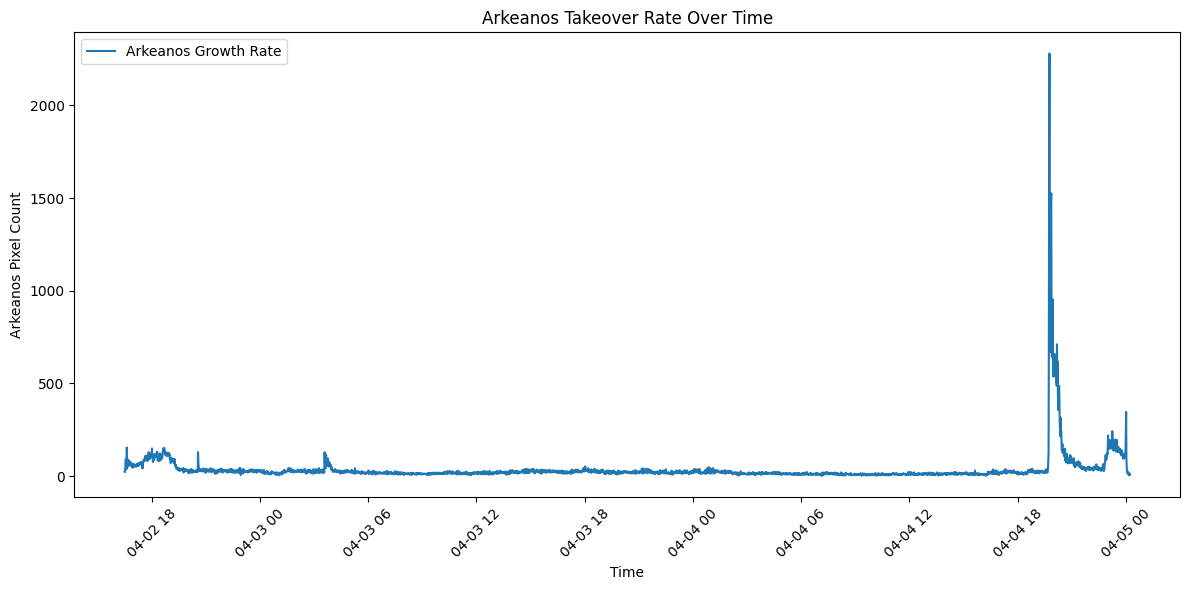

In [65]:
new = new.with_columns(
    pl.col("pixel_color").is_in(arkeanos_colors).alias("is_arkeanos") # new column is_arkeanos
)

growth_over_time = new.group_by("time_bin").agg(
    pl.sum("is_arkeanos").alias("arkeanos_growth") # sum pixels that are arkeanos every minute
)

growth_over_time_pd = growth_over_time.to_pandas()

plt.figure(figsize=(12, 6))
plt.plot(growth_over_time_pd["time_bin"], growth_over_time_pd["arkeanos_growth"], label="Arkeanos Growth Rate")
plt.xlabel("Time")
plt.ylabel("Arkeanos Pixel Count")
plt.title("Arkeanos Takeover Rate Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

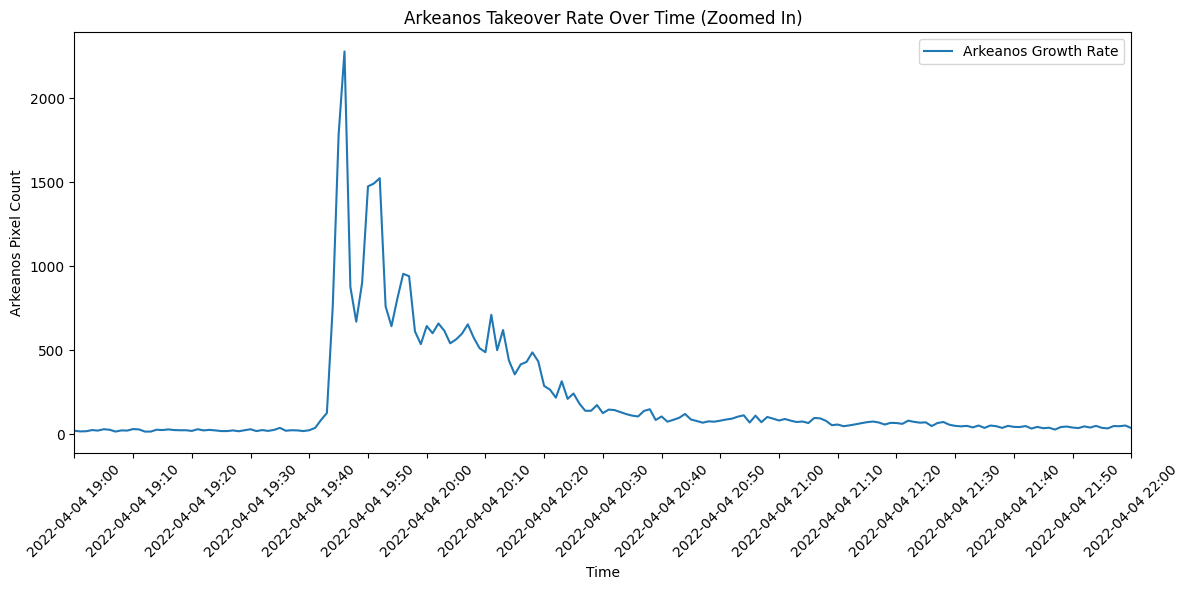

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(growth_over_time_pd["time_bin"], growth_over_time_pd["arkeanos_growth"], label="Arkeanos Growth Rate")
plt.xlabel("Time")
plt.ylabel("Arkeanos Pixel Count")
plt.title("Arkeanos Takeover Rate Over Time (Zoomed In)")

plt.xlim(pd.to_datetime("2022-04-04 19:00:00"), pd.to_datetime("2022-04-04 22:00:00")) # zoom in
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=10)) # 30 min separator
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M")) # reformat x-axis 
plt.xticks(rotation=45) # rotate

plt.tight_layout()
plt.legend()
plt.show()

- Was the takeover sudden (viral spread) or gradual?
    - sudden at time 2022-04-04 19:30
- Was there resistance (temporary decline, slow growth)?
    - pretty much no resistance, as white out soon
- What was the peak takeover period
    - 2022-04-04 19:30 - 2022-04-04 20:20 (30 min)

2. bot detection?
- high freq of pixel changes sugget bot activity?
- check unique user id

In [14]:
# number of times pixel was changed in general
df_repeats = (
    arkeanos_data
    .group_by(["x", "y"])
    .agg(pl.count("time_bin").alias("pixel_count"))
    .sort("pixel_count", descending=True)
    .collect()) 

df_repeats.head(10)

x,y,pixel_count
i64,i64,u32
1672,77,30
1672,76,30
1671,77,26
1671,76,23
1673,76,21
1651,89,21
1677,133,19
1652,91,18
1672,78,18


In [14]:
# number of times pixel was changes by specific user
df_user_activity = (
    lf
    .filter(
        (pl.col("x") >= 1615) & (pl.col("x") <= 1717) &  # X range
        (pl.col("y") >= 48) & (pl.col("y") <= 147) &    # Y range
        (pl.col("timestamp") >= pl.lit("2022-04-04 19:30:00").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")) & 
        (pl.col("timestamp") <= pl.lit("2022-04-04 20:20:00").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S"))  # Time range
    )
    .group_by("user_id_int")
    .agg(pl.len().alias("pixel_changes")) # count num of pixel changes per user
    .sort("pixel_changes", descending=True)  
    .collect()
)

df_user_activity.head(10)

user_id_int,pixel_changes
u32,u32
124189,5
37954,5
121905,4
2796,4
214972,4
157853,4
137670,4
66879,4
153310,4


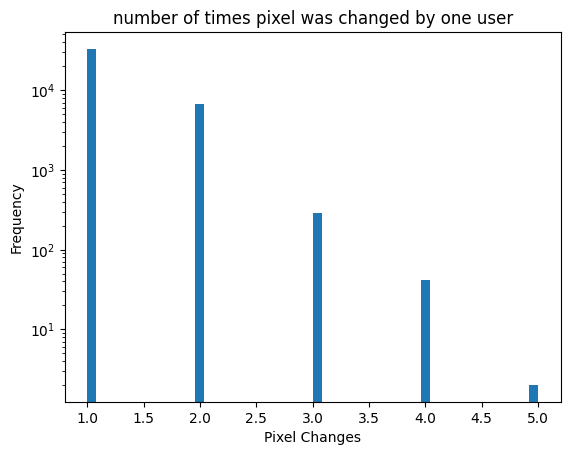

In [24]:
plt.hist(df_user_activity["pixel_changes"], bins=50, log=True)
plt.title("number of times pixel was changed by one user")
plt.xlabel("Pixel Changes")
plt.ylabel("Frequency")
plt.show()

seems to be fine, only 5 changes at most within about an hour
but look at how often change (more specific, time between each change)

In [43]:
# time difference for each change by each user
df_time_diff = (
    lf
    .filter(
        (pl.col("x") >= 1615) & (pl.col("x") <= 1717) &  # X range
        (pl.col("y") >= 48) & (pl.col("y") <= 147) &    # Y range
        (pl.col("timestamp") >= pl.lit("2022-04-04 19:30:00").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")) & 
        (pl.col("timestamp") <= pl.lit("2022-04-04 20:20:00").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S"))  # Time range
    )
    .group_by(["user_id_int", "x", "y"])  
    .agg([pl.col("timestamp").first().alias("first_timestamp")])  # get first timestamp for each user/pixel combo
    .sort("user_id_int", "first_timestamp") 
    .with_columns(
        (pl.col("first_timestamp") - pl.col("first_timestamp").shift(1)).alias("time_diff")  # time difference between changes
    )
    .filter(pl.col("time_diff").is_not_null())  # remove NaN (first entry for each user)
    .sort("time_diff")  # sort by time diff (smallest to largest)
    .collect()
)

df_time_diff.head(10)



user_id_int,x,y,first_timestamp,time_diff
u32,i64,i64,datetime[μs],duration[μs]
244036,1628,114,2022-04-04 19:30:14.980,-49m -5s -341ms
198329,1695,49,2022-04-04 19:30:25.310,-48m -22s -160ms
201939,1687,84,2022-04-04 19:30:28.571,-48m -21s -357ms
206234,1687,84,2022-04-04 19:30:32.605,-48m -20s -324ms
210981,1699,60,2022-04-04 19:30:37.045,-48m -19s -280ms
216032,1618,61,2022-04-04 19:30:41.744,-48m -18s -64ms
223756,1701,49,2022-04-04 19:30:49.070,-48m -16s -37ms
224810,1659,66,2022-04-04 19:30:50.061,-48m -15s -757ms
235764,1672,85,2022-04-04 19:31:00.638,-48m -13s -352ms


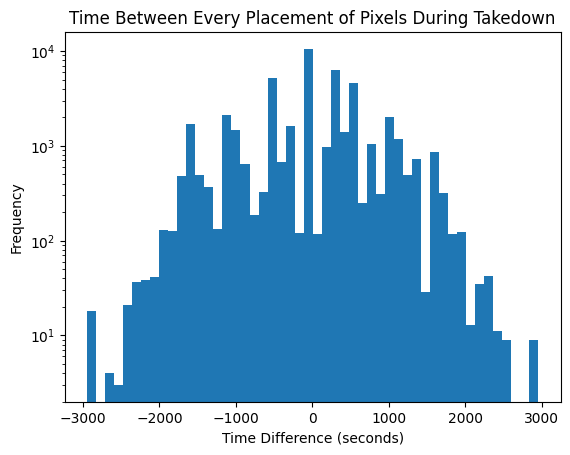

In [44]:
df_time_diff = df_time_diff.with_columns(
    (pl.col("time_diff").cast(pl.Duration).dt.total_seconds()).alias("time_diff_sec")
)

plt.hist(df_time_diff["time_diff_sec"], bins=50, log=True)
plt.title("Time Between Every Placement of Pixels During Takedown")
plt.xlabel("Time Difference (seconds)")
plt.ylabel("Frequency")
plt.show()

In [38]:
# count unique users 
df_unique_takeover = (
    lf
    .filter(
        (pl.col("x") >= 1615) & (pl.col("x") <= 1717) &  # X range
        (pl.col("y") >= 48) & (pl.col("y") <= 147) &    # Y range
        (pl.col("timestamp") >= pl.lit("2022-04-04 19:30:00").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")) & 
        (pl.col("timestamp") <= pl.lit("2022-04-04 20:20:00").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S"))  # Time range
    )
    .select(pl.col('user_id_int'))
    # .collect()
    # .n_unique()
)

df_unique_takeover.collect().n_unique()

40009